<a href="https://colab.research.google.com/github/Leonardoup11/Assignment04/blob/master/newHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import statistics
from sklearn.model_selection import train_test_split
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,8,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,7,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,7,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,8,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,7,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0
5,3787000140,20140901T000000,3,2.25,1780,9969,1.0,0,0,3,8,1450,330,1985,0,98034,47.7286,-122.168,1950,7974,450000.0
6,7852110690,20140522T000000,4,2.50,2980,8107,2.0,0,0,3,9,2980,0,2000,0,98065,47.5389,-121.876,2750,7760,622500.0
7,5469700260,20140903T000000,4,2.25,2530,24700,2.0,0,0,3,7,2530,0,1974,0,98031,47.3939,-122.177,2650,24700,340000.0
8,8691410730,20150220T000000,4,2.50,3090,5600,2.0,0,0,3,9,3090,0,2005,0,98075,47.5970,-121.979,3080,5788,708000.0
9,114100763,20140728T000000,3,0.75,1040,15000,1.0,0,0,3,6,1040,0,1941,0,98028,47.7639,-122.234,1410,19000,230000.0


In [26]:
housing.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.000000e+04,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,2.000000e+04
mean,4.580297e+09,3.370200,2.115750,2079.883100,1.501533e+04,1.49645,0.007550,0.234900,3.409700,7.657700,1790.232900,289.650200,1971.100150,82.732150,98077.876850,47.559970,-122.213897,1986.387500,12748.96040,5.394367e+05
std,2.875295e+09,0.931931,0.770134,919.433672,3.970135e+04,0.54095,0.086564,0.767692,0.651895,1.175287,829.587101,441.537072,29.374008,397.872344,53.438026,0.138517,0.140649,685.211515,27076.48904,3.664334e+05
min,1.000102e+06,0.000000,0.000000,290.000000,5.200000e+02,1.00000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.00000,7.500000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.00000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.750000,0.000000,98033.000000,47.470675,-122.328000,1490.000000,5100.00000,3.220000e+05
50%,3.904955e+09,3.000000,2.250000,1910.000000,7.620000e+03,1.50000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571450,-122.230000,1840.000000,7622.00000,4.500000e+05
75%,7.309825e+09,4.000000,2.500000,2550.000000,1.071000e+04,2.00000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678000,-122.124000,2360.000000,10088.25000,6.416250e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.164794e+06,3.50000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.00000,7.700000e+06


In [27]:

#create column for when a house was last updated
new_renovations = []
for built, renovated in zip(housing['yr_built'], housing['yr_renovated']):
  
  if renovated == 0:
    new_renovations.append(built)
  else:
      new_renovations.append(renovated)

housing['last_update'] = new_renovations
housing['year_check'] = housing.date.astype(str).str[:4]
housing['year_check'] =pd.to_numeric(housing['year_check'])
housing['yrs_ago'] = housing.year_check - housing.last_update

binary_renovation = housing['yr_renovated']

for i in housing['yr_renovated']:
  if i >0:
    housing['was_renovated'] = housing['yr_renovated'].replace(i, 1)


housing['decade'] = pd.cut(x=housing['last_update'], bins=[1900, 1909, 1919, 1929,1939, 1949, 1959,1969,  1979,1989, 1999,  2009, 2019], 
                             labels=[1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970,1980, 1990,2000,2010])
housing['decade'] =pd.to_numeric(housing['decade'])

housing['yrs_ago'] = pd.cut(x=housing['yrs_ago'], bins=[-1, 9, 19, 29,39, 49, 59,69,  79,89, 99,  109, 119], 
                             labels=[0, 10, 20, 30, 40, 50, 60, 70,80, 90,100,110])
housing['yrs_ago'] =pd.to_numeric(housing['yrs_ago'])





feature_df = pd.DataFrame()
ziplist = list(housing.zipcode.unique())


for i in ziplist:
 
      zip_df = housing[housing.zipcode == i]
      
      diff = zip_df.lat.max()-zip_df.lat.min()
      diff5 = diff/2
      one = zip_df.lat.min()
      two = zip_df.lat.min()+diff5
      three = zip_df.lat.max()
        
      bins = [one, two, three]

      labels = [zip_df.lat.min(),zip_df.lat.max()]
      zip_df['new_lat'] = pd.cut(zip_df['lat'], bins=bins, labels = labels)


  
      diff = zip_df.long.max()-zip_df.long.min()
      diff5 = diff/2
      one = zip_df.long.min()
      two = zip_df.long.min()+diff5
      three = zip_df.long.max()
      
      bins = [one, two, three]
    
    

      labels = [zip_df.long.min(),zip_df.long.max()]
      zip_df['new_long'] = pd.cut(zip_df['long'], bins=bins, labels = labels)


  


      feature_df =feature_df.append(zip_df)

      

      feature_df['new_lat'] =pd.to_numeric(feature_df['new_lat'])
      feature_df['new_long'] =pd.to_numeric(feature_df['new_long'])




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [28]:

df = feature_df.drop(['id', 'date', 'yr_renovated','yr_built', 'lat','long' ], axis = 1)
df.head(10)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,price,last_update,year_check,yrs_ago,was_renovated,decade,new_lat,new_long
0,4,3.25,3760,4675,2.0,0,0,3,8,2740,1020,98038,3280,4033,429900.0,2007,2014,0.0,0,2000.0,47.3438,-122.079
28,4,2.50,2600,5188,2.0,0,0,3,8,2600,0,98038,2610,5188,359900.0,2005,2015,10.0,0,2000.0,47.3438,-122.079
36,3,2.50,1890,3629,2.0,0,0,3,7,1890,0,98038,1980,4000,285000.0,2005,2014,0.0,0,2000.0,47.3438,-122.079
47,5,2.50,3180,23809,1.0,0,0,3,9,3180,0,98038,2500,15778,499950.0,1978,2014,30.0,0,1970.0,47.3438,-122.079
77,3,2.50,2720,62310,1.0,0,0,3,8,2040,680,98038,2770,204296,550000.0,1985,2015,30.0,0,1980.0,47.4583,-122.079
107,4,2.25,2230,6791,2.0,0,0,3,8,2230,0,98038,2420,6297,340000.0,2005,2014,0.0,0,2000.0,47.3438,-122.079
135,3,2.50,3370,167706,1.0,0,0,3,10,3370,0,98038,3350,213444,713900.0,2000,2015,10.0,0,2000.0,47.4583,-122.079
160,3,3.00,1850,19966,1.0,0,0,4,7,1090,760,98038,1410,6715,287200.0,1992,2014,20.0,0,1990.0,47.3438,-122.079
164,2,1.75,910,2550,1.0,0,0,3,6,910,0,98038,1310,2550,193000.0,2004,2015,10.0,0,2000.0,47.3438,-122.079
174,3,1.75,1350,155073,1.0,0,0,4,7,1350,0,98038,1560,50965,385000.0,1969,2014,40.0,0,1960.0,47.4583,-121.936


In [29]:
X = housing[['waterfront', 'view', 'zipcode', 'lat', 'sqft_lot', 'sqft_lot15', 'long']]
y = housing['price']



X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
import statsmodels.api as sm
p_model = sm.OLS(y_test, X_test).fit()
p_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.778
Method:                 Least Squares   F-statistic:                              7992.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):                        0.00
Time:                        23:04:27   Log-Likelihood:                     -2.2476e+05
No. Observations:               16000   AIC:                                  4.495e+05
Df Residuals:                   15993   BIC:                                  4.496e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
waterfront  4.474e+05   3.12e+04     14.324      0.000    3.86e+05    5.09e+05
view        1.664e+05   3467.406     47.977      0.000     1.6e+05    1.73e+05
zipcode     -461.6128     28.105    -16.425      0.000    -516.702    -406.524
lat         9.126e+05    1.8e+04     50.692      0.000    8.77e+05    9.48e+05
sqft_lot       0.6394      0.094      6.803      0.000       0.455       0.824
sqft_lot15     0.4121      0.134      3.080      0.002       0.150       0.674
long       -1.924e+04   2.13e+04     -0.905      0.365   -6.09e+04    2.24e+04
==============================================================================
Omnibus:                    14331.751   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1208572.979
Skew:                           3.963   Prob(JB):                         0.00
Kurtosis:                      44.834   Cond. No.                     1.30e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
clf = XGBRegressor(max_depth=7, min_child_weight=9)
#clf = XGBRegressor()
clf.fit(X_train, y_train)
#'learning_rate': 0.17101473065144568, 'max_depth': 4, 'n_estimators': 655, 'subsample': 0.787457836953852}
#{'learning_rate': 0.1350529083028733, 'max_depth': 4, 'n_estimators': 698, 'subsample': 0.9263646802836745}

[23:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=9, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [32]:
predictions = clf.predict(X_test)
predictions

array([691894.06, 854316.06, 415381.5 , ..., 467608.75, 542258.7 ,
       255515.28], dtype=float32)

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
result = r2_score(y_test, predictions)

result = mean_squared_error(y_test, predictions, squared=False)
result

212706.89279253685

In [34]:
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, predictions)

r2_score

0.6522613581895889

In [35]:
from sklearn.metrics import classification_report

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

waterfront    0.557408
view          0.200602
lat           0.075025
zipcode       0.074171
long          0.033275
sqft_lot15    0.030573
sqft_lot      0.028947
dtype: float32

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [37]:
X = housing[['view', 'sqft_living', 'grade', 'waterfront', 'lat', 'zipcode']]
y = housing['price']


X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
overall_model = XGBRegressor(max_depth=6, colsample_bytree=0.7)
overall_model.fit(X_train, y_train)


[23:04:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
overall_predictions = overall_model.predict(X_test)
overall_predictions

array([608435.6 , 718729.75, 368132.34, ..., 464346.47, 575136.7 ,
       295625.3 ], dtype=float32)

In [40]:
# randm = RandomizedSearchCV(estimator=overall_model, param_distributions = parameters,
#                                cv = 2, n_iter = 10, n_jobs=-1)
# randm.fit(X_train, y_train)

# print(" Results from Random Search " )
# print("The best estimator across ALL searched params:", randm.best_estimator_)
# print("The best score across ALL searched params:", randm.best_score_)
# print("The best parameters across ALL searched params:", randm.best_params_)

In [41]:
# Root Mean Squared Error Value
overall_result = mean_squared_error(y_test, overall_predictions, squared=False)
overall_result

139541.59978765983

In [42]:
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, overall_predictions)

r2_score

0.850342935654785

In [43]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

In [44]:
# Find the important variables
importance = overall_model.feature_importances_

df = pd.DataFrame(list(zip(importance, X.columns.to_list())), columns =['importance', 'feature'])
print(importance, X.columns.to_list())
df.head()


[0.04287615 0.11795613 0.38059    0.3501965  0.063802   0.04457917] ['view', 'sqft_living', 'grade', 'waterfront', 'lat', 'zipcode']


,importance,feature
0,0.042876,view
1,0.117956,sqft_living
2,0.380590,grade
3,0.350197,waterfront
4,0.063802,lat


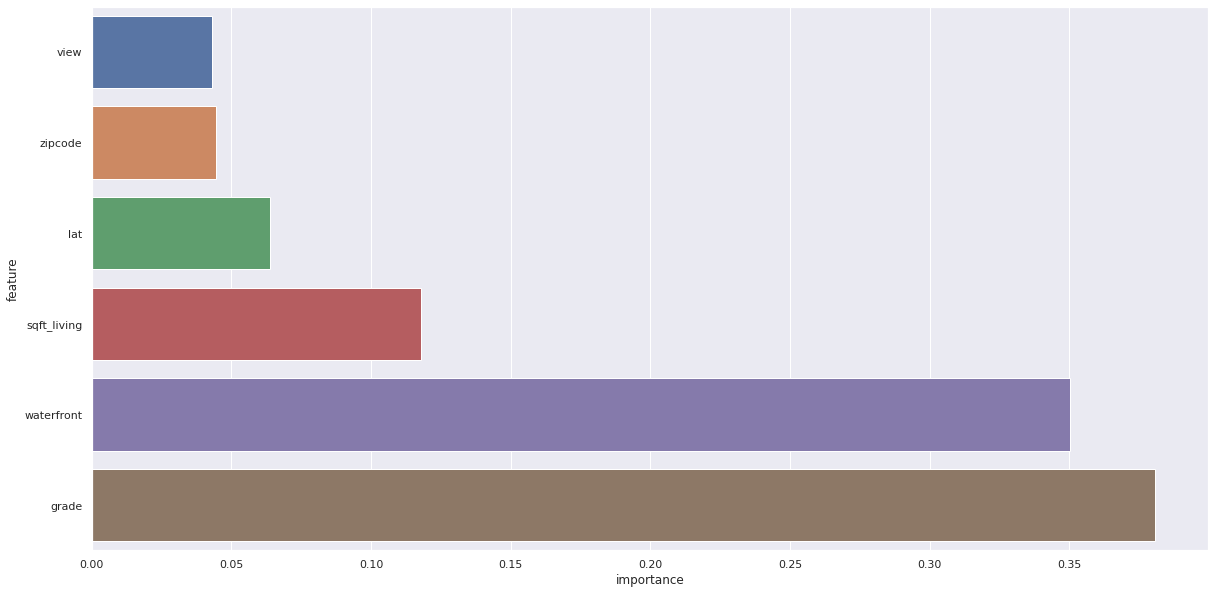

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df.sort_values(by='importance')

plt.figure(figsize=(20, 10))
sns.set(font_scale = 1)
ax = sns.barplot(data=df, x='importance', y='feature')
plt.show()

In [46]:
housing2 = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

# New Section

In [47]:
new_predictions = overall_model.predict(housing2[['view', 'sqft_living', 'grade', 'waterfront', 'lat', 'zipcode']])
print(new_predictions)

import csv
dict = {'price': new_predictions}
df = pd.DataFrame(dict) 

# saving the dataframe 
df.to_csv('test_data_module_03.csv')

[ 371210.03  817416.6  1427772.6  ...  259558.7  1609439.8   340635.62]
